In [144]:
import pandas as pd
import json
import folium, json
import numpy as np 
import statsmodels.api as sm 
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr 
from statsmodels.stats.multitest import multipletests

In [145]:
weather_df = pd.read_csv("../data/raw/weather/weather.csv")

# should be run only ONCE
weather_df["TemperatureAboveGround"] = weather_df["TemperatureAboveGround"] - 273.15

sweden_weather_df = weather_df[weather_df["iso3166-2"].str.startswith("SE")]

#weather variables per day per region


corona_df = pd.read_csv("../data/raw/corona/se_corona.csv", sep = "\t")
#number of cases per day per region

corona_df = corona_df.rename(columns = {"confirmed_addition":"cases"})

with open("../data/raw/metadata/se_metadata.json", "r", encoding="utf-8") as f:
    country_metadata = json.load(f)

#population and region code per region


In [146]:
# Stringency Index

str_df = pd.read_csv("../data/raw/corona/stringency_index.csv")
str_df = str_df[(str_df["country_name"] == "Sweden")]

str_df = str_df.transpose()
str_df = str_df[3:].dropna() #dropping NA values


str_df = str_df.reset_index()
str_df = str_df.rename(columns={"index": "date", 157: "stringency_index"})

#changing string object to datetime
str_df["date"] = pd.to_datetime(str_df["date"])

In [147]:
#check for missing data
sweden_weather_df.isna().any().any()
corona_df.isna().any().any()
#cannot run a "isna" on dictionary, should we check for empty key?

False

In [148]:
region_map = {country_metadata["country_metadata"][i]["covid_region_code"]: country_metadata["country_metadata"][i]["iso3166-2_code"] for i in range (len(country_metadata["country_metadata"]))
}

corona_df ["region"] = corona_df["region_code"].map(region_map)

In [149]:
population_map = {country_metadata["country_metadata"][i]["iso3166-2_code"]: country_metadata["country_metadata"][i]["population"] for i in range (len(country_metadata["country_metadata"]))
}

corona_df["population"] = corona_df["region"].map(population_map) #adding another column
corona_df["cases_per_capita"] = corona_df["cases"]/corona_df["population"] #adding our factor - cases per capita

In [150]:
#ADDED NEW VARIABLE - DENSITY
density_map = {country_metadata["country_metadata"][i]["iso3166-2_code"]: country_metadata["country_metadata"][i]["population_density"] for i in range (len(country_metadata["country_metadata"]))
}

corona_df["population_density"] = corona_df["region"].map(density_map) #adding another column

In [151]:
merged_df = corona_df.merge(sweden_weather_df, left_on=["date", "region"], right_on= ["date", "iso3166-2"]) 
#it matches two arguments, not merges on them. If you call the same thing twice, there will be one coulmn, but if you call two, it's different

merged_df = merged_df.drop("iso3166-2", axis = 1)
merged_df = merged_df.rename(columns = {"region_code":"region_name", "region": "region_code"})

merged_df["date"] = pd.to_datetime(merged_df["date"]) #converting string type to datetime to match in merge with SI

In [152]:
full_df = merged_df.merge(str_df, on = "date") 

full_df

,date,region_name,cases,region_code,population,cases_per_capita,population_density,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed,stringency_index
0,2021-02-18,Blekinge,23,SE-K,159606,0.000144,52.0,91.958400,4.169385e+05,2.424771e+06,-0.351750,0.000317,0.572565,4.132720,69.44
1,2021-02-18,Dalarna,78,SE-W,287966,0.000271,10.0,83.472412,5.560170e+05,2.327816e+06,-6.324020,0.000902,0.000000,2.789497,69.44
2,2021-02-18,Gotland,3,SE-I,59686,0.000050,19.0,76.066474,1.217169e+06,2.449967e+06,-3.398588,0.000011,2.044527,4.697774,69.44
3,2021-02-18,Gävleborg,234,SE-X,287382,0.000814,16.0,77.955185,1.722268e+06,2.383899e+06,-5.956068,0.000124,0.000000,2.564518,69.44
4,2021-02-18,Halland,187,SE-N,333848,0.000560,59.0,91.276936,6.979065e+03,2.410299e+06,0.282810,0.000647,0.000000,4.960031,69.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7807,2020-02-13,Västernorrland,0,SE-Y,245347,0.000000,11.0,83.230208,1.351595e+06,2.320155e+06,-6.075210,0.000045,0.000000,1.497883,5.56
7808,2020-02-13,Västmanland,0,SE-U,275845,0.000000,37.0,71.129740,3.511075e+06,2.373874e+06,-0.460946,0.000000,0.000000,2.593358,5.56
7809,2020-02-13,Västra_Götaland,0,SE-O,1725881,0.000000,68.0,77.017705,3.841654e+06,2.370478e+06,1.299874,0.000039,0.792579,3.868366,5.56
7810,2020-02-13,Örebro,0,SE-T,304805,0.000000,35.0,69.266165,3.927441e+06,2.358019e+06,-0.298819,0.000000,0.000000,3.391266,5.56


In [153]:
Xs= ["RelativeHumiditySurface", "SolarRadiation", "Surfacepressure", "TemperatureAboveGround", "Totalprecipitation", "UVIndex", "WindSpeed"]


In [154]:

map_df = full_df.groupby(by = "region_code")["cases_per_capita"].sum().reset_index()
#GeoJson has codes, not names. So, it is important to map by codes
#Also, for good map experience, I have to sum all the cases for each region

map_df["population_density"] = map_df["region_code"].map(density_map) #adding density column
map_df['density_log'] = np.log(map_df['population_density']) #adding another column with log
map_df

,region_code,cases_per_capita,population_density,density_log
0,SE-AB,0.062821,360.0,5.886104
1,SE-AC,0.048595,4.9,1.589235
2,SE-BD,0.046543,2.6,0.955511
3,SE-C,0.061004,45.0,3.806662
4,SE-D,0.042475,52.0,3.951244
5,SE-E,0.047236,43.0,3.761200
6,SE-F,0.069632,34.0,3.526361
7,SE-G,0.067241,23.0,3.135494
8,SE-H,0.044006,22.0,3.091042
9,SE-I,0.044634,19.0,2.944439


In [155]:
#MAPPING

#1) CASES PER CAPITA

#Our preferred way - if we map cases & population we can see that the data overlaps. Therefore, to get rid of
#the population factor, we calculate cases per capita and show them on a map. We can see that northernmost regions
#have low cases per capita, so maybe the more sun we have, the more cases we have? It's worth noting that Stockholm doesn't 
#have the most cases per capita, so it's not only the matter of population density. ACTUALLY, LET'S MAP POPULATION DENSITY

map_cases_capita = folium.Map(location = [63,15], zoom_start = 4, tiles = "OpenStreetMap")

folium.Choropleth(
    geo_data = "../data/raw/shapefiles/se.geojson",
    name = "cases",
    data = map_df,
    columns=["region_code", "cases_per_capita"],
    key_on = "feature.properties.iso_3166_2",
    fill_color = "OrRd",
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name="Cases per Capita"
).add_to(map_cases_capita)

map_cases_capita


In [156]:
#new dataset - people per square kilometer. Added to raw -> se country metadata manually
#Density is log transformed - it was basically all-white without it

map_density = folium.Map(location = [63,15], zoom_start = 4, tiles = "OpenStreetMap")

folium.Choropleth(
    geo_data = "../data/raw/shapefiles/se.geojson",
    name = "density",
    data = map_df,
    columns=["region_code", "density_log"],
    key_on = "feature.properties.iso_3166_2",
    fill_color = "OrRd",
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name="Population Density Log"
).add_to(map_density)

map_density

#We've taken care of population and density, so we are good to go with weather. However, we can't be sure, so that's a limitation
#Maybe there are just weaker people in some regions? Living closely together, and not evenly distributed? We won't know

In [157]:
twomaps = folium.Map(location = [63,15], zoom_start = 4, tiles = "OpenStreetMap")

#map_cases_capita
folium.Choropleth(
    geo_data = "../data/raw/shapefiles/se.geojson",
    name = "cases",
    data = map_df,
    columns=["region_code", "cases_per_capita"],
    key_on = "feature.properties.iso_3166_2",
    fill_color = "OrRd",
    fill_opacity = 0.8,
    line_opacity = 0.2,
    legend_name="Cases per Capita"
).add_to(twomaps)

#map_density
folium.Choropleth(
    geo_data = "../data/raw/shapefiles/se.geojson",
    name = "density",
    data = map_df,
    columns=["region_code", "density_log"],
    key_on = "feature.properties.iso_3166_2",
    fill_color = "OrRd",
    fill_opacity = 0.8,
    line_opacity = 0.2,
    legend_name="Population Density Log"
).add_to(twomaps)

folium.LayerControl().add_to(twomaps)

twomaps

In [158]:
significance_threshold = 0.05/(len(Xs)*3)

print("Linear")
for var in Xs: 
    corr, pvalue = pearsonr(full_df["cases"], full_df[var])
    print(f"{var}\n{corr:.3f}\t{pvalue}\t{pvalue < significance_threshold}\n")
#SPearman
print("Spearman")
for var in Xs: 
    corr, pvalue = spearmanr(full_df["cases"], full_df[var])
    print(f"{var}\n{corr:.3f}\t{pvalue}\t{pvalue < significance_threshold}\n")
#Log
print("Log")
for var in Xs: 
    corr, pvalue = pearsonr(np.log(full_df["cases"]+1), full_df[var])
    print(f"{var}\n{corr:.3f}\t{pvalue}\t{pvalue < significance_threshold}\n")

#We did this as a first step, but it's inconclusive, meaning that things are probably too much interconnected (6/7 return True).
#So, we need to perform multivarite analysis / regression on that


Linear
RelativeHumiditySurface
0.217	3.907016922024001e-84	True

SolarRadiation
-0.222	5.0086720589042216e-88	True

Surfacepressure
0.130	6.031849091292155e-31	True

TemperatureAboveGround
-0.148	1.8154672522899836e-39	True

Totalprecipitation
0.016	0.15940712901941428	False

UVIndex
-0.233	4.673663032768274e-97	True

WindSpeed
0.043	0.00016318892865581133	True

Spearman
RelativeHumiditySurface
0.267	9.832250385730405e-128	True

SolarRadiation
-0.342	2.440997668619903e-213	True

Surfacepressure
0.155	2.411947739843351e-43	True

TemperatureAboveGround
-0.217	7.300739352215883e-84	True

Totalprecipitation
0.005	0.6392701606505318	False

UVIndex
-0.357	3.5946834739162764e-233	True

WindSpeed
-0.044	9.061463229959151e-05	True

Log
RelativeHumiditySurface
0.231	2.604923083457697e-95	True

SolarRadiation
-0.237	7.023729900514718e-100	True

Surfacepressure
0.175	8.922852858988767e-55	True

TemperatureAboveGround
-0.213	8.560860967206382e-81	True

Totalprecipitation
-0.025	0.030077619016782336

In [159]:
Xs= ["RelativeHumiditySurface", "SolarRadiation", "Surfacepressure", "TemperatureAboveGround", "Totalprecipitation", "UVIndex", "WindSpeed"]
pvalues = []
tests = ("linear", "spearman", "log")

for var in Xs:
    corr, pvalue = pearsonr(full_df["cases"], full_df[var])
    pvalues.append(pvalue)
for var in Xs:
    corr, pvalue = spearmanr(full_df["cases"], full_df[var])
    pvalues.append(pvalue)


for var in Xs: 
    corr, pvalue = pearsonr(np.log(full_df["cases"]+1), full_df[var])
    pvalues.append(pvalue)
    
significant, pholmcorrected, _ , _ = multipletests(pvalues, alpha = 0.05, method = "holm")

for i in range(len(significant)):
    print(f"{tests[i // len(Xs)]}\t{Xs[i % len(Xs)]}\t{significant[i]}")


linear	RelativeHumiditySurface	True
linear	SolarRadiation	True
linear	Surfacepressure	True
linear	TemperatureAboveGround	True
linear	Totalprecipitation	False
linear	UVIndex	True
linear	WindSpeed	True
spearman	RelativeHumiditySurface	True
spearman	SolarRadiation	True
spearman	Surfacepressure	True
spearman	TemperatureAboveGround	True
spearman	Totalprecipitation	False
spearman	UVIndex	True
spearman	WindSpeed	True
log	RelativeHumiditySurface	True
log	SolarRadiation	True
log	Surfacepressure	True
log	TemperatureAboveGround	True
log	Totalprecipitation	False
log	UVIndex	True
log	WindSpeed	True


In [160]:
full_df["cases_per_capita"] = full_df["cases_per_capita"].round(4) #rounding for mode which we didn't use

[ 5.56       12.65777778 19.75555556 26.85333333 33.95111111 41.04888889
 48.14666667 55.24444444 62.34222222 69.44      ]


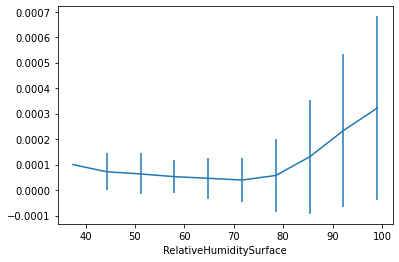

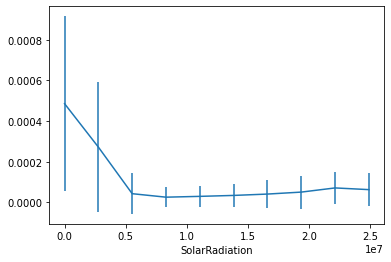

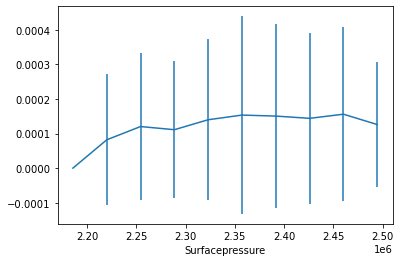

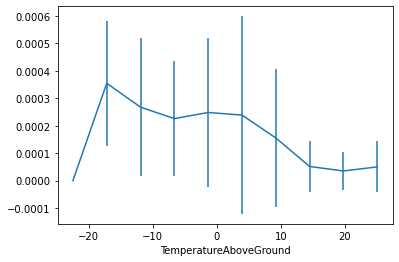

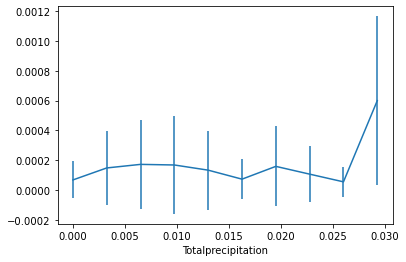

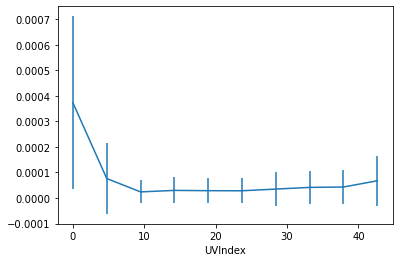

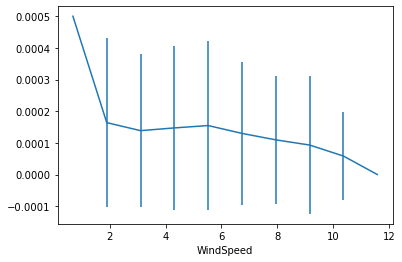

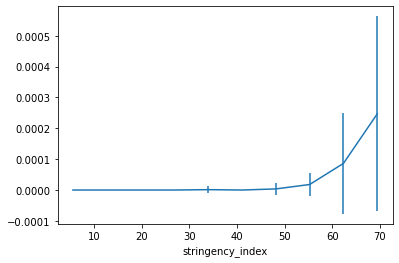

In [161]:
print(insert)

Xs = ["RelativeHumiditySurface", "SolarRadiation", "Surfacepressure", "TemperatureAboveGround", "Totalprecipitation", "UVIndex", "WindSpeed", "stringency_index"]



for var in Xs:
    mean = []
    standard_deviation = []
    
    insert = np.linspace(full_df[var].min(), full_df[var].max(), 10)
    #insert.append(full_df[var].max() * ((i+1)/10))

    previous_i = -1
    for i in insert:

        #first you trim vertically by the cases number between previous i and i quantiles, and then you choose 
        #the variable var, and append it to mean list, then changing it to a dataframee

        mean.append(full_df[full_df[var].between(previous_i, i, inclusive = "right")]["cases_per_capita"].mean()) 
        standard_deviation.append(full_df[full_df[var].between(previous_i, i, inclusive = "right")]["cases_per_capita"].std())
        previous_i = i
    
    # print('\n' + var + '\n')
    df_temp = pd.DataFrame({"insert": insert, "mean": mean, "sd": standard_deviation}).fillna(0)
    # print(df_temp)

    
    # Subplots as having two types of quality
    df_temp.plot('insert', 'mean', yerr='sd', legend = None, xlabel = var)
